## 1. Visualise confusion matrices for interventions

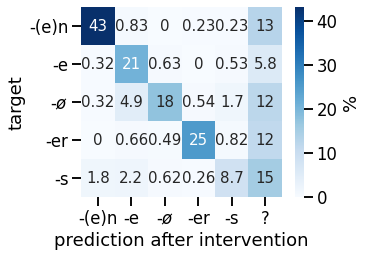

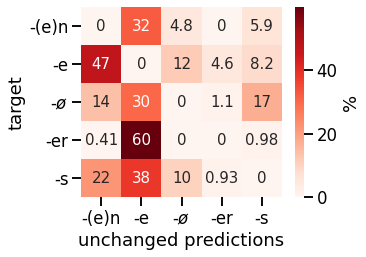

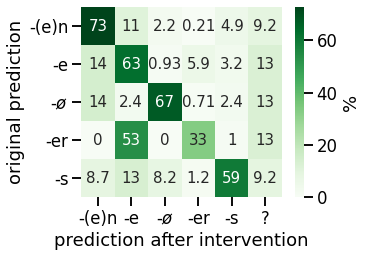

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
import unidecode
import sys
sys.path.append("../wiktionary")
from categorise import categorise
from collections import Counter, defaultdict

targets = Counter()
prediction_counter = Counter()
after_invention = []
unchanged = []
prediction_before = []
before_after = []

for model_seed in [1, 2, 3, 4, 5]:
    for dc_seed in [1, 2, 3, 4, 5]:
        filename = f"trace/trace_epoch=5_lr=2.0" + \
                   f"_model-seed={model_seed}_dc-seed={dc_seed}_dc" + \
                   f"-lr=0.00025_exclude-incorrect=False_random-dc=False.txt"
        with open(filename, encoding="utf-8") as f:
            for line in f:
                if "- source" in line:
                    source = line.split()[2]
                    source = " ".join([source[:3]] + list(source[3:-5]))
                    prediction = " ".join(list(line.split()[4][:-1]))
                    intervention = " ".join(list(line.split()[6][:-1]))
                    target = " ".join(list(line.split()[8][:-1]))
                    #print(target, prediction, intervention)
                    intervention = str(categorise(source, intervention))
                    prediction = str(categorise(source, prediction))
                    target = str(categorise(source, target))
                    
                    target, prediction, intervention = line.split()[-1].split('/')
                    if intervention == "6":
                        intervention = "5"
                    targets[int(target)] += 1
                    prediction_counter[int(prediction)] += 1
                    if prediction != intervention:
                        after_invention.append((target, intervention))
                    else:
                        unchanged.append((target, intervention))
                    prediction_before.append((target, prediction))
                    before_after.append((prediction, intervention))

plt.figure(figsize=(4.5, 3.5))
true, pred = zip(*after_invention)
matrix = confusion_matrix(true, pred)[:5]
matrix = [[num / targets[i] * 100 for num in row]
           for i, row in enumerate(matrix)]
ax = sns.heatmap(matrix, cmap="Blues", cbar_kws={'label': '%'}, annot=True, annot_kws={"fontsize": 15})
ax.set_xticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s", "?"])
ax.set_yticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s"], rotation=0)
plt.xlabel("prediction after intervention")
plt.ylabel("target")
plt.savefig("figures/changed_interventions.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(4.5, 3.5))
true, pred = zip(*unchanged)
matrix = confusion_matrix(true, pred)
matrix = [[num / targets[i] * 100 for num in row]
           for i, row in enumerate(matrix)]
ax = sns.heatmap(matrix, cmap="Reds", cbar_kws={'label': '%'}, annot=True, annot_kws={"fontsize": 15})
ax.set_xticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s"])
ax.set_yticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s"], rotation=0)
plt.xlabel("unchanged predictions")
plt.ylabel("target")
plt.savefig("figures/unchanged_interventions.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(4.5, 3.5))
true, pred = zip(*before_after)
matrix = confusion_matrix(true, pred)[:5]
matrix = [[num / prediction_counter[i] * 100 for num in row]
           for i, row in enumerate(matrix)]
ax = sns.heatmap(matrix, cmap="Greens", cbar_kws={'label': '%'}, annot=True, annot_kws={"fontsize": 15})
ax.set_xticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s", "?"])
ax.set_yticklabels(["-(e)n", "-e", r"-$\o$", "-er", "-s"], rotation=0)
plt.xlabel("prediction after intervention")
plt.ylabel("original prediction")
plt.savefig("figures/predictions_before_after.pdf", bbox_inches="tight")
plt.show()

## 2. Visualise the effect of $\alpha$

In [4]:
targets = Counter()
prediction_counter = Counter()

performances = defaultdict(list)
nonsense = defaultdict(list)

lrs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
for lr in lrs:
    after_invention = []
    targets = Counter()
    for model_seed in [1, 2, 3, 4, 5]:
        for dc_seed in [1]:
            filename = f"trace/trace_epoch=5_lr={lr}" + \
                           f"_model-seed={model_seed}_dc-seed={dc_seed}_dc" + \
                           f"-lr=0.00025_exclude-incorrect=True_random-dc=False.txt"
            with open(filename, encoding="utf-8") as f:
                for line in f:
                    if "- source" in line:
                        target, prediction, intervention = line.split()[-1].split('/')
                        if intervention == "6":
                            intervention = "5"
                        if prediction != intervention:
                            after_invention.append((target, intervention))
                        targets[int(target)] += 1
    true, pred = zip(*after_invention)
    matrix = confusion_matrix(true, pred)[:5]
    for i in range(5):
        performances[i].append(matrix[i][i] / targets[i] * 100)
        nonsense[i].append(matrix[i][5] / targets[i] * 100)

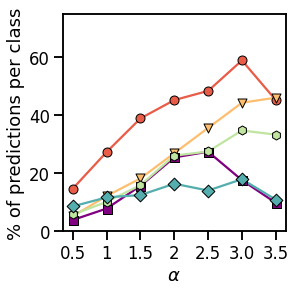

In [11]:
markers = ['o', 'v', 's', 'h', 'D', 'o']

fig = plt.figure(figsize=(4, 4))
colours = sns.color_palette("Spectral", 5)
colours[2] = "purple"
sns.lineplot(x=lrs, y=performances[0], color=colours[0], zorder=-1)
sns.lineplot(x=lrs, y=performances[1], color=colours[1], zorder=-1)
sns.lineplot(x=lrs, y=performances[2], color=colours[2], zorder=-1)
sns.lineplot(x=lrs, y=performances[3], color=colours[3], zorder=-1)
ax = sns.lineplot(x=lrs, y=performances[4], color=colours[4], zorder=-1)
sns.scatterplot(x=lrs, y=performances[0], color=colours[0], linewidth=1, edgecolor='black', marker=markers[0])
sns.scatterplot(x=lrs, y=performances[1], color=colours[1], linewidth=1, edgecolor='black', marker=markers[1])
sns.scatterplot(x=lrs, y=performances[2], color=colours[2], linewidth=1, edgecolor='black', marker=markers[2])
sns.scatterplot(x=lrs, y=performances[3], color=colours[3], linewidth=1, edgecolor='black', marker=markers[3])
ax = sns.scatterplot(x=lrs, y=performances[4], color=colours[4], linewidth=1, edgecolor='black', marker=markers[4])

lrs = [.5, 1, 1.5, 2, 2.5, 3.0, 3.5]
ax.set_xticks(lrs)
ax.set_xticklabels(lrs)
plt.ylabel("% of predictions per class")
plt.xlabel(r"$\alpha$")
plt.ylim(0, 75)
plt.savefig("figures/learning_rates.pdf", bbox_inches="tight")
plt.show()

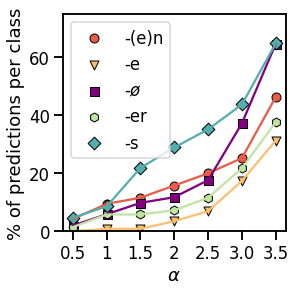

In [14]:
fig = plt.figure(figsize=(4, 4))
colours = sns.color_palette("Spectral", 5)
colours[2] = "purple"
sns.lineplot(x=lrs, y=nonsense[0], color=colours[0])
sns.lineplot(x=lrs, y=nonsense[1], color=colours[1])
sns.lineplot(x=lrs, y=nonsense[2], color=colours[2])
sns.lineplot(x=lrs, y=nonsense[3], color=colours[3])
ax = sns.lineplot(x=lrs, y=nonsense[4], color=colours[4])
sns.scatterplot(x=lrs, y=nonsense[0], color=colours[0], label="-(e)n",linewidth=1, edgecolor='black',  marker=markers[0])
sns.scatterplot(x=lrs, y=nonsense[1], color=colours[1], label="-e", linewidth=1, edgecolor='black', marker=markers[1])
sns.scatterplot(x=lrs, y=nonsense[2], color=colours[2], label=r"-$\o$", linewidth=1, edgecolor='black', marker=markers[2])
sns.scatterplot(x=lrs, y=nonsense[3], color=colours[3], label="-er", linewidth=1, edgecolor='black', marker=markers[3])
ax = sns.scatterplot(x=lrs, y=nonsense[4], color=colours[4], label="-s", linewidth=1, edgecolor='black', marker=markers[4])

lrs = [.5, 1, 1.5, 2, 2.5, 3.0, 3.5]
ax.set_xticks(lrs)
ax.set_xticklabels(lrs)
plt.ylabel("% of predictions per class")
plt.xlabel(r"$\alpha$")
plt.ylim(0, 75)
plt.savefig("figures/learning_rates_nonsense.pdf", bbox_inches="tight")
plt.show()